In [49]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import DriftingGratings

from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
client = OPhysClient("/Users/chase/Desktop/test_v1dd_data")

In [3]:
session = client.load_ophys_session(mouse=409828, column=1, volume=3)

In [4]:
plane = 1
dgw = DriftingGratings(session, plane=plane, dg_type="windowed", quick_load=True)
dgf = DriftingGratings(session, plane=plane, dg_type="full", quick_load=True)

In [5]:
running_speed = session.get_running_speed()

Text(0.5, 1.0, 'Stationary vs running DGW trials')

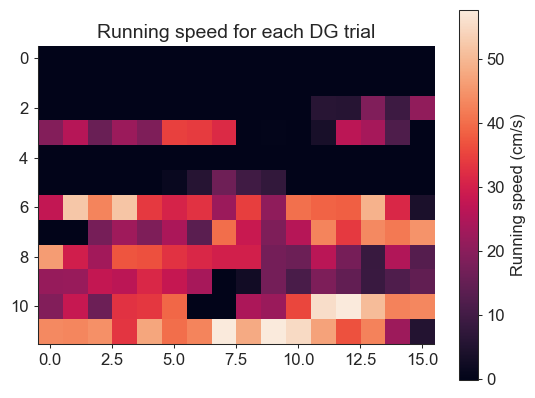

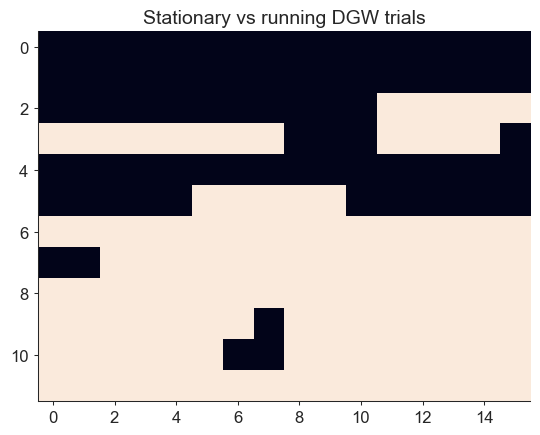

In [6]:
RUNNING_THRESHOLD = 1 # cm/s
RUNNING_PADDING = 0.5 # s; padding around stimulus onset/offset to get running trace

stim_table = dgf.stim_table
running_speed_by_stim_trial = np.empty(len(stim_table), dtype=float)

for i, row in stim_table.iterrows():
    start = row["start"] - RUNNING_PADDING
    end = row["end"] + RUNNING_PADDING
    mean_run = running_speed.sel(time=slice(start, end)).mean().item() # cm/s; mean running speed during stimulus sweep
    running_speed_by_stim_trial[i] = mean_run

im = running_speed_by_stim_trial.reshape((12, -1))
plt.imshow(im)
plt.colorbar(label="Running speed (cm/s)")
plt.title("Running speed for each DG trial")
plt.figure()
is_running = np.where(np.isnan(im), np.nan, im > RUNNING_THRESHOLD)
plt.imshow(is_running)
plt.title("Stationary vs running DGW trials")

In [7]:
dgw.sweep_responses.shape

(192, 1234)

In [8]:
dgw.blank_responses

array([[0.        , 0.        , 0.00133179, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0042104 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00119549, ..., 0.00134324, 0.00144668,
        0.        ],
       [0.        , 0.        , 0.00211578, ..., 0.        , 0.        ,
        0.00237879],
       [0.        , 0.        , 0.00172342, ..., 0.        , 0.        ,
        0.        ]])

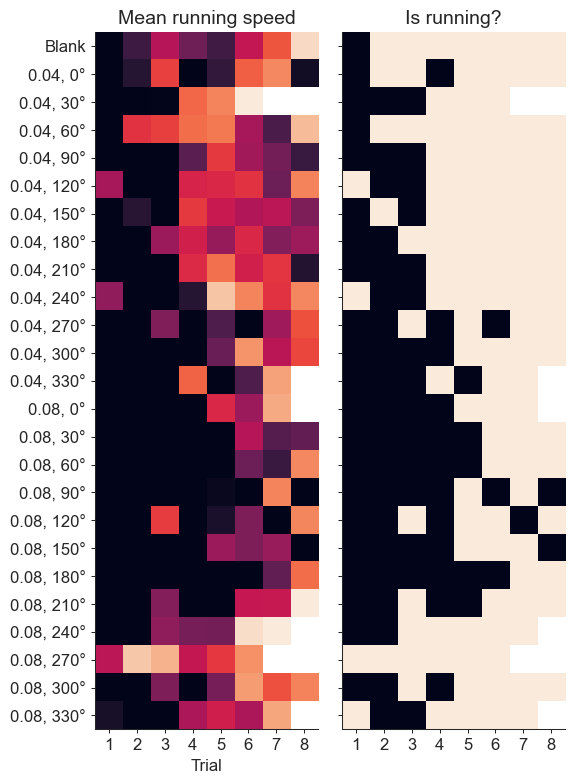

In [9]:
sf_list = sorted(stim_table.spatial_frequency.dropna().unique())
dir_list = sorted(stim_table.direction.dropna().unique())
mean_run_by_stim_category = np.full((1 + len(sf_list)*len(dir_list), dgw.n_trials), np.nan) # +1 for blank trial
# trial_responses_by_stim_category = mean_run_by_stim_category.copy()

# null trial
for j, stim_i in enumerate(dgw.get_stim_idx(None, None)):
    mean_run_by_stim_category[0, j] = running_speed_by_stim_trial[stim_i]
    # trial_responses_by_stim_category[0, j] = dgw.d

for sf_i, sf in enumerate(sf_list):
    for dir_i, dir in enumerate(dir_list):
        cat_i = 1 + sf_i*len(dir_list) + dir_i

        for j, stim_i in enumerate(dgw.get_stim_idx(dir, sf)):
            mean_run_by_stim_category[cat_i, j] = running_speed_by_stim_trial[stim_i]

xticks = np.arange(mean_run_by_stim_category.shape[1])
xticklabels = xticks + 1
yticks = np.arange(mean_run_by_stim_category.shape[0])
yticklabels = []
for i in yticks:
    if i == 0:
        yticklabels.append("Blank")
    else:
        i -= 1
        sf_i = int(i / len(dir_list))
        dir_i = i - sf_i*len(dir_list)
        yticklabels.append(f"{sf_list[sf_i]:.2f}, {dir_list[dir_i]:.0f}°")

fig, axs = plt.subplots(figsize=(6, 8), ncols=2)

ax = axs[0]
ax.set_title("Mean running speed")
ax.imshow(mean_run_by_stim_category)
ax.set_yticks(ticks=yticks, labels=yticklabels)
ax.set_xlabel("Trial")
ax.set_xticks(ticks=xticks, labels=xticklabels)

ax = axs[1]
ax.set_title("Is running?")
is_running = np.where(np.isnan(mean_run_by_stim_category), np.nan, mean_run_by_stim_category > RUNNING_THRESHOLD)
ax.imshow(is_running)
ax.set_yticks(ticks=yticks, labels=[])
ax.set_xticks(ticks=xticks, labels=xticklabels)


fig.tight_layout()

In [10]:
dgw.metrics

Loading DG-windowed response metrics for session M409828_13, plane 1...


,pref_response,pref_dir,pref_sf,pref_dir_idx,pref_sf_idx,pref_dir_mean,z_score,response_p,osi,gosi,...,p_trial_responses,sig_trial_responses,norm_dir_responses,is_valid,pref_ori,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std
0,0.001098,30,0.04,1,0,6.878321,2.711068,0.0067,0.187371,0.049596,...,0.219745,False,"[0.2702723294781112, 0.703625551188055, -0.049...",True,30,0.14,0.000432,0.000246,0.000421,0.000684
1,0.001196,0,0.04,0,0,7.964158,1.976538,0.0323,0.490517,0.074137,...,0.488223,False,"[1.2204922950849642, 0.9002977704583234, 1.079...",True,0,0.41,0.000576,0.000314,0.000568,0.000897
2,0.000964,210,0.08,7,1,285.264595,0.003651,0.4642,0.415835,0.254687,...,0.682848,False,"[-0.16521713143760408, -0.43962260845206835, -...",True,30,0.65,0.000962,0.000527,0.00095,0.001478
3,0.001798,120,0.04,4,0,122.003812,2.164707,0.0312,0.620734,0.243435,...,0.360503,False,"[0.038727293644160096, -0.29980215121168613, 0...",True,120,0.34,0.000765,0.000477,0.00077,0.001346
4,0.001154,210,0.04,7,0,274.544879,0.46577,0.2435,0.22724,0.111571,...,0.527325,False,"[1.8701646676177215, 1.289373851620474, 0.9082...",True,30,0.64,0.000872,0.000605,0.000871,0.001732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.93,0.000502,0.000291,0.00051,0.000834
1230,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.19,0.000359,0.000249,0.000363,0.000711
1231,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.17,0.000374,0.000246,0.000373,0.000707
1232,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.01,0.000826,0.000444,0.000851,0.001261


In [12]:
dgf.metrics

Loading DG-full response metrics for session M409828_13, plane 1...


,pref_response,pref_dir,pref_sf,pref_dir_idx,pref_sf_idx,pref_dir_mean,z_score,response_p,osi,gosi,...,p_trial_responses,sig_trial_responses,norm_dir_responses,is_valid,pref_ori,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std
0,0.00119,0,0.04,0,0,344.394353,3.086617,0.0033,0.475473,0.133519,...,0.454744,False,"[3.0692306640191798, 0.0, 0.8196492615719009, ...",True,0,0.45,0.00043,0.000246,0.000429,0.00069
1,0.000967,330,0.08,11,1,186.033921,1.250154,0.1151,0.725392,0.219281,...,0.733166,False,"[-0.47005193044201793, -0.01562719226299424, -...",True,150,0.79,0.000572,0.000315,0.000561,0.000898
2,0.000997,0,0.04,0,0,0.720385,0.049298,0.4406,0.304752,0.13728,...,0.453478,False,"[-0.2626754274505367, -0.8200596739095797, -0....",True,0,0.31,0.000971,0.000528,0.000971,0.00149
3,0.002335,120,0.04,4,0,63.918717,3.252288,0.0066,0.364305,0.288559,...,0.003738,True,"[0.763225770808046, 1.1005525590861363, 0.5532...",True,120,0.04,0.000774,0.00048,0.000778,0.001351
4,0.001463,120,0.04,4,0,226.724078,0.947161,0.1461,0.673527,0.344926,...,0.123745,False,"[0.621744183824697, -0.3967493470006739, -0.39...",True,120,0.12,0.000883,0.000613,0.000884,0.001764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.33,0.000502,0.000291,0.000498,0.00082
1230,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.18,0.00036,0.000249,0.000367,0.000711
1231,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.51,0.000377,0.00025,0.000377,0.000707
1232,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.65,0.000832,0.000447,0.000828,0.001252


In [13]:
dgw.metrics.columns

Index(['pref_response', 'pref_dir', 'pref_sf', 'pref_dir_idx', 'pref_sf_idx',
       'pref_dir_mean', 'z_score', 'response_p', 'osi', 'gosi', 'dsi',
       'frac_responsive_trials', 'lifetime_sparseness', 'p_trial_responses',
       'sig_trial_responses', 'norm_dir_responses', 'is_valid', 'pref_ori',
       'chisq_response_p', 'null_dist_multi_mean', 'null_dist_multi_std',
       'null_dist_single_mean', 'null_dist_single_std'],
      dtype='object')

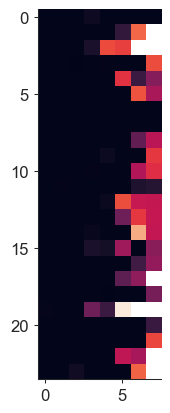

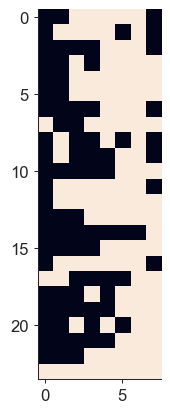

In [55]:
def get_run_speed_xr(dg: DriftingGratings, running_padding=0.5):
    run_speed_xr = xr.DataArray(
        data=np.nan,
        name="running_speeds",
        dims=("direction", "spatial_frequency", "trial"), # Could include temporal frequency, but there is only 1 value (1)
        coords=dict(
            direction=dg.dir_list,
            spatial_frequency=dg.sf_list,
            trial=range(dg.n_trials)
        )
    )

    for dir in dg.dir_list:
        for sf in dg.sf_list:
            stim_idx = dg.get_stim_idx(dir, sf)

            for j, stim_i in enumerate(stim_idx):
                start = dg.stim_table.at[stim_i, "start"] - running_padding
                end = dg.stim_table.at[stim_i, "end"] + running_padding
                mean_run = running_speed.sel(time=slice(start, end)).mean().item() # cm/s; mean running speed during stimulus sweep
                run_speed_xr.loc[dict(direction=dir, spatial_frequency=sf, trial=j)] = mean_run

    return run_speed_xr

dgw_run_speed_xr = get_run_speed_xr(dgw)
dgf_run_speed_xr = get_run_speed_xr(dgf)

plt.imshow(dgw_run_speed_xr.values.reshape(24, -1))
plt.figure()
plt.imshow((dgf_run_speed_xr.values > 1).reshape(24, -1))

In [178]:
with h5py.File("../../data_frames/dg-events.h5", "r") as f:
    print(f.keys())

<KeysViewHDF5 ['M409828', 'M416296', 'M427836', 'M438833']>


/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_72205/1805484630.py:78: RuntimeWarning: invalid value encountered in double_scalars
  ssi_running.append((w-f)/(w+f))
/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_72205/1805484630.py:67: RuntimeWarning: invalid value encountered in double_scalars
  ssi_stationary.append((w-f)/(w+f))
/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_72205/1805484630.py:53: RuntimeWarning: invalid value encountered in double_scalars
  ssi_avg_pref_tf_running.append((tf_mean_dgw_resp_running - tf_mean_dgf_resp_running) / (tf_mean_dgw_resp_running + tf_mean_dgf_resp_running))


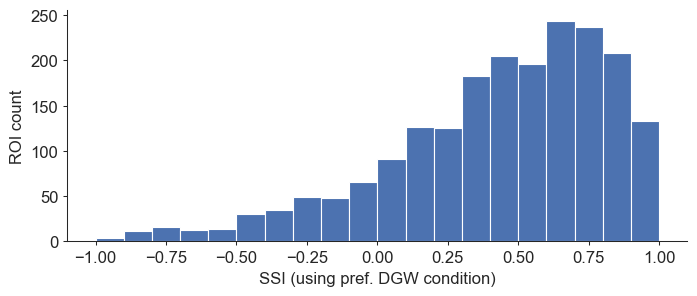

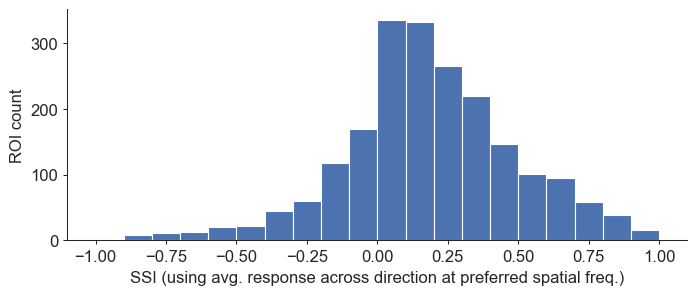

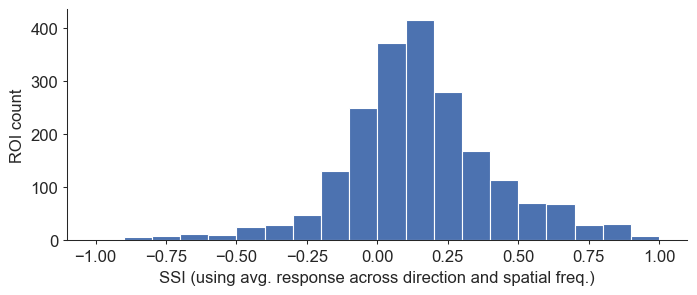

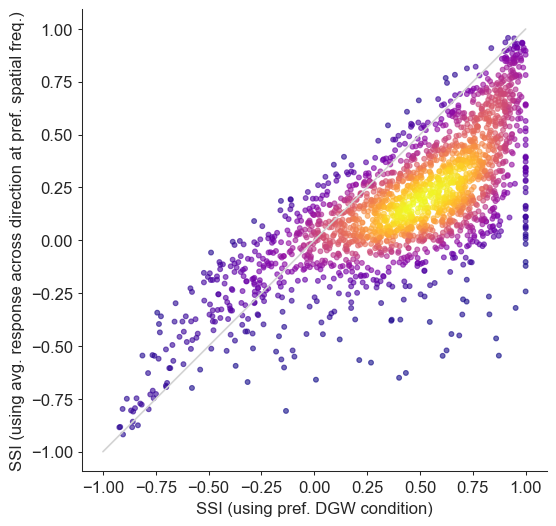

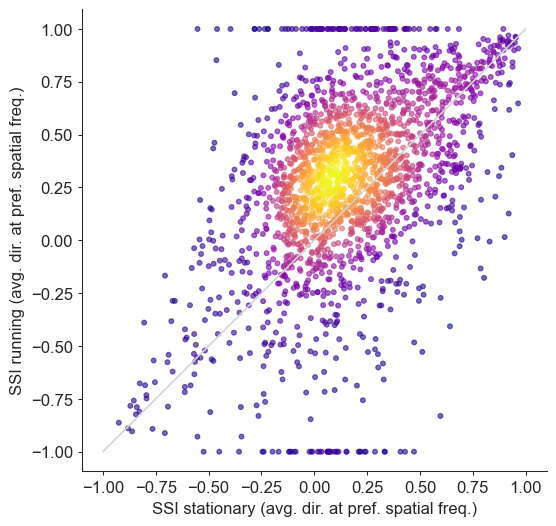

In [227]:
import h5py

with h5py.File("../../data_frames/dg-events.h5", "r") as file:
    ssi = []
    ssi_avg_pref_tf = []
    ssi_avg = []
    ssi_avg_pref_tf_stationary = []
    ssi_avg_pref_tf_running = []
    ssi_stationary = []
    ssi_running = []

    for mouse_id in ["M409828"]:
    # for mouse_id in file.keys():
        for cv_key in file[mouse_id].keys():
            if cv_key[0] != "1": continue # Only column 1
            for plane_key in file[mouse_id][cv_key].keys():
                group = file[mouse_id][cv_key][plane_key]

                # dgw_trial_responses = DriftingGratings.load_dg_xarray_from_h5(group["windowed"], "trial_responses")
                # dgf_trial_responses = DriftingGratings.load_dg_xarray_from_h5(group["full"], "trial_responses")
                dgw_trial_responses = group["windowed"]["trial_responses"][()]
                dgf_trial_responses = group["full"]["trial_responses"][()]
                dgw_run = group["windowed"]["trial_running_speeds"][()]
                dgf_run = group["full"]["trial_running_speeds"][()]

                responsive_rois = np.where(group["windowed"]["is_responsive"][()])[0]
                # responsive_rois = np.where(group["windowed"]["is_responsive"][()] | group["full"]["is_responsive"][()])[0]

                dgw_pref_cond_idxs = group["windowed"]["pref_cond_index"][()]

                dgw_is_running = dgw_run > RUNNING_THRESHOLD
                dgw_is_stationary = dgw_run < RUNNING_THRESHOLD
                dgf_is_running = dgf_run > RUNNING_THRESHOLD
                dgf_is_stationary = dgf_run < RUNNING_THRESHOLD

                for roi in responsive_rois:
                    pref_dir_idx, pref_sf_idx = dgw_pref_cond_idxs[roi]

                    mean_dgw_resp = np.nanmean(dgw_trial_responses[roi])
                    mean_dgf_resp = np.nanmean(dgf_trial_responses[roi])
                    ssi_avg.append((mean_dgw_resp - mean_dgf_resp) / (mean_dgw_resp + mean_dgf_resp))

                    tf_mean_dgw_resp = np.nanmean(dgw_trial_responses[roi, :, pref_sf_idx])
                    tf_mean_dgf_resp = np.nanmean(dgf_trial_responses[roi, :, pref_sf_idx])
                    ssi_avg_pref_tf.append((tf_mean_dgw_resp - tf_mean_dgf_resp) / (tf_mean_dgw_resp + tf_mean_dgf_resp))

                    pref_dgw_resp = np.nanmean(dgw_trial_responses[roi, pref_dir_idx, pref_sf_idx])
                    dgf_resp_pref_dgw = np.nanmean(dgf_trial_responses[roi, pref_dir_idx, pref_sf_idx])
                    ssi.append((pref_dgw_resp - dgf_resp_pref_dgw) / (pref_dgw_resp + dgf_resp_pref_dgw))

                    tf_mean_dgw_resp_running = np.nanmean(np.where(dgw_is_running, dgw_trial_responses, np.nan)[roi, :, pref_sf_idx]) # dgw.trial_responses.where(dgw_is_running).sel(roi=roi, spatial_frequency=dgw_pref_sf).mean().item()
                    tf_mean_dgf_resp_running = np.nanmean(np.where(dgf_is_running, dgf_trial_responses, np.nan)[roi, :, pref_sf_idx]) # dgf.trial_responses.where(dgf_is_running).sel(roi=roi, spatial_frequency=dgw_pref_sf).mean().item()
                    ssi_avg_pref_tf_running.append((tf_mean_dgw_resp_running - tf_mean_dgf_resp_running) / (tf_mean_dgw_resp_running + tf_mean_dgf_resp_running))

                    tf_mean_dgw_resp_stationary = np.nanmean(np.where(dgw_is_stationary, dgw_trial_responses, np.nan)[roi, :, pref_sf_idx]) # dgw.trial_responses.where(dgw_is_stationary).sel(roi=roi, spatial_frequency=dgw_pref_sf).mean().item()
                    tf_mean_dgf_resp_stationary = np.nanmean(np.where(dgf_is_stationary, dgf_trial_responses, np.nan)[roi, :, pref_sf_idx]) # dgf.trial_responses.where(dgf_is_stationary).sel(roi=roi, spatial_frequency=dgw_pref_sf).mean().item()
                    ssi_avg_pref_tf_stationary.append((tf_mean_dgw_resp_stationary - tf_mean_dgf_resp_stationary) / (tf_mean_dgw_resp_stationary + tf_mean_dgf_resp_stationary))

                    ws = np.where(dgw_is_stationary, dgw_trial_responses, np.nan)[roi, pref_dir_idx, pref_sf_idx]
                    fs = np.where(dgf_is_stationary, dgf_trial_responses, np.nan)[roi, pref_dir_idx, pref_sf_idx]
                    ws = ws[~np.isnan(ws)]
                    fs = fs[~np.isnan(fs)]
                    n_trials_required = 3
                    if len(ws) >= n_trials_required and len(fs) >= n_trials_required:
                        w = ws.mean()
                        f = fs.mean()
                        ssi_stationary.append((w-f)/(w+f))
                    else:
                        ssi_stationary.append(np.nan)
                    
                    wr = np.where(dgw_is_running, dgw_trial_responses, np.nan)[roi, pref_dir_idx, pref_sf_idx]
                    fr = np.where(dgf_is_running, dgf_trial_responses, np.nan)[roi, pref_dir_idx, pref_sf_idx]
                    wr = wr[~np.isnan(wr)]
                    fr = fr[~np.isnan(fr)]
                    if len(wr) >= n_trials_required and len(fr) >= n_trials_required:
                        w = wr.mean()
                        f = fr.mean()
                        ssi_running.append((w-f)/(w+f))
                    else:
                        ssi_running.append(np.nan)
                        

    plt.figure(figsize=(8, 3))
    plt.hist(ssi, bins=np.arange(-1, 1.1, 0.1))
    plt.xlabel("SSI (using pref. DGW condition)")
    plt.ylabel("ROI count")

    plt.figure(figsize=(8, 3))
    plt.hist(ssi_avg_pref_tf, bins=np.arange(-1, 1.1, 0.1))
    plt.xlabel("SSI (using avg. response across direction at preferred spatial freq.)")
    plt.ylabel("ROI count")

    plt.figure(figsize=(8, 3))
    plt.hist(ssi_avg, bins=np.arange(-1, 1.1, 0.1))
    plt.xlabel("SSI (using avg. response across direction and spatial freq.)")
    plt.ylabel("ROI count")

    plt.figure(figsize=(6, 6))
    # plt.scatter(ssi_avg, ssi)
    # plt.ylabel("SSI (using avg. response across direction and spatial freq.)")
    at.density_scatter(ssi, ssi_avg_pref_tf, ax=plt.gca())
    plt.xlabel("SSI (using pref. DGW condition)")
    plt.ylabel("SSI (using avg. response across direction at pref. spatial freq.)")
    plt.axis("equal")
    plt.plot([-1, 1], [-1, 1], color="lightgray")

    plt.figure(figsize=(6, 6))
    at.density_scatter(ssi_avg_pref_tf_stationary, ssi_avg_pref_tf_running, ax=plt.gca())
    plt.xlabel("SSI stationary (avg. dir. at pref. spatial freq.)")
    plt.ylabel("SSI running (avg. dir. at pref. spatial freq.)")
    plt.axis("equal")
    plt.plot([-1, 1], [-1, 1], color="lightgray")

KstestResult(statistic=0.21734939759036145, pvalue=2.502182804712954e-43, statistic_location=0.27335100080334834, statistic_sign=-1)

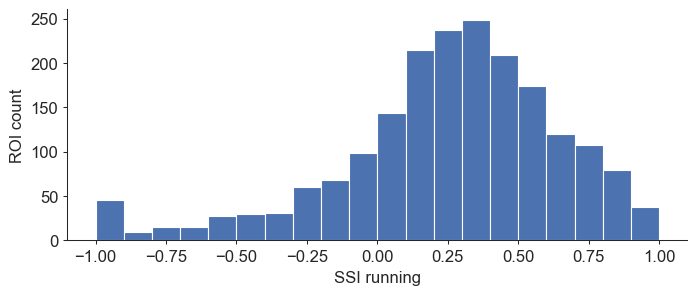

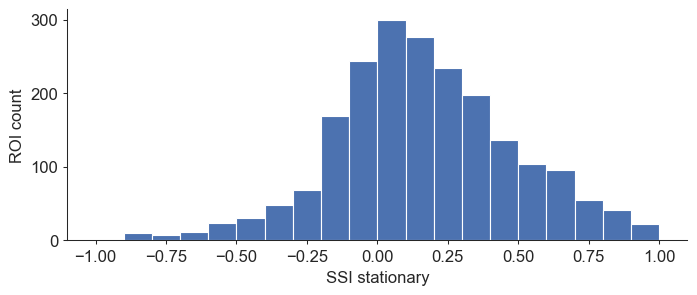

In [228]:
plt.figure(figsize=(8, 3))
plt.hist(ssi_avg_pref_tf_running, bins=np.arange(-1, 1.1, 0.1))
plt.xlabel("SSI running")
plt.ylabel("ROI count")

plt.figure(figsize=(8, 3))
plt.hist(ssi_avg_pref_tf_stationary, bins=np.arange(-1, 1.1, 0.1))
plt.xlabel("SSI stationary")
plt.ylabel("ROI count")

st.kstest(ssi_avg_pref_tf_running, ssi_avg_pref_tf_stationary)

189 0.0910843373493976


KstestResult(statistic=0.13227513227513227, pvalue=0.07319150362985023, statistic_location=0.08296933021755318, statistic_sign=-1)

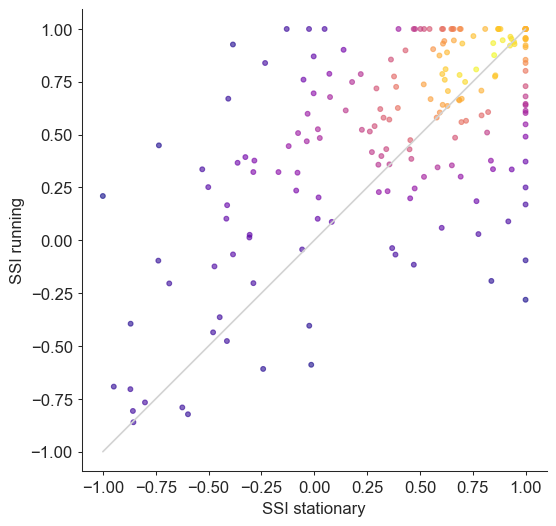

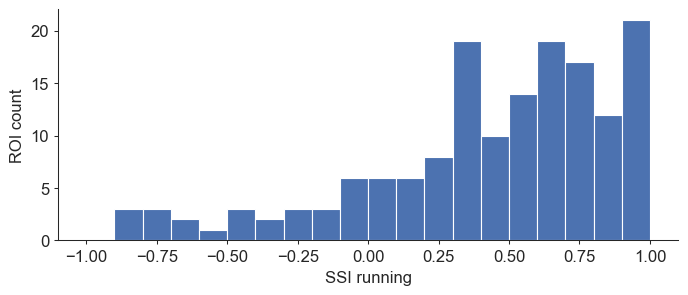

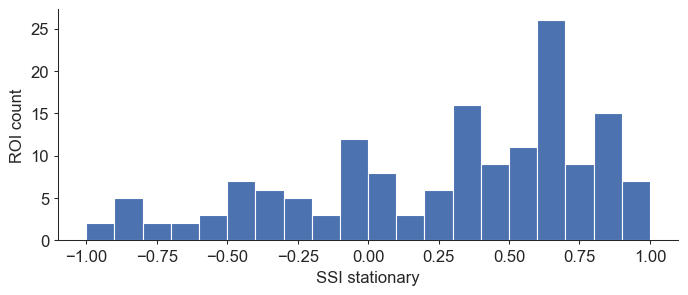

In [229]:
mask = (~np.isnan(ssi_stationary) & ~np.isnan(ssi_running))
print(mask.sum(), mask.mean())

plt.figure(figsize=(6, 6))
stat = np.array(ssi_stationary)[mask]
run = np.array(ssi_running)[mask]
at.density_scatter(x=stat, y=run, ax=plt.gca())
plt.axis("equal")
plt.xlabel("SSI stationary")
plt.ylabel("SSI running")
plt.plot([-1, 1], [-1, 1], color="lightgray")

plt.figure(figsize=(8, 3))
plt.hist(run, bins=np.arange(-1, 1.1, 0.1))
plt.xlabel("SSI running")
plt.ylabel("ROI count")

plt.figure(figsize=(8, 3))
plt.hist(stat, bins=np.arange(-1, 1.1, 0.1))
plt.xlabel("SSI stationary")
plt.ylabel("ROI count")

st.kstest(run, stat)

In [118]:
dgw.trial_responses.coords

Coordinates:
  * roi                (roi) int64 0 1 2 3 4 5 ... 1228 1229 1230 1231 1232 1233
  * direction          (direction) int64 0 30 60 90 120 ... 210 240 270 300 330
  * spatial_frequency  (spatial_frequency) float64 0.04 0.08
  * trial              (trial) int64 0 1 2 3 4 5 6 7

In [106]:
(dgw.metrics.is_valid & (dgw.metrics.frac_responsive_trials >= 0.25)).values.astype(bool)

0.2252836304700162

In [108]:
dgw.metrics

,pref_response,pref_dir,pref_sf,pref_dir_idx,pref_sf_idx,pref_dir_mean,z_score,response_p,osi,gosi,...,p_trial_responses,sig_trial_responses,norm_dir_responses,is_valid,pref_ori,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std
0,0.001098,30,0.04,1,0,6.878321,2.711068,0.0067,0.187371,0.049596,...,0.219745,False,"[0.2702723294781112, 0.703625551188055, -0.049...",True,30,0.14,0.000432,0.000246,0.000421,0.000684
1,0.001196,0,0.04,0,0,7.964158,1.976538,0.0323,0.490517,0.074137,...,0.488223,False,"[1.2204922950849642, 0.9002977704583234, 1.079...",True,0,0.41,0.000576,0.000314,0.000568,0.000897
2,0.000964,210,0.08,7,1,285.264595,0.003651,0.4642,0.415835,0.254687,...,0.682848,False,"[-0.16521713143760408, -0.43962260845206835, -...",True,30,0.65,0.000962,0.000527,0.00095,0.001478
3,0.001798,120,0.04,4,0,122.003812,2.164707,0.0312,0.620734,0.243435,...,0.360503,False,"[0.038727293644160096, -0.29980215121168613, 0...",True,120,0.34,0.000765,0.000477,0.00077,0.001346
4,0.001154,210,0.04,7,0,274.544879,0.46577,0.2435,0.22724,0.111571,...,0.527325,False,"[1.8701646676177215, 1.289373851620474, 0.9082...",True,30,0.64,0.000872,0.000605,0.000871,0.001732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.93,0.000502,0.000291,0.00051,0.000834
1230,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.19,0.000359,0.000249,0.000363,0.000711
1231,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.17,0.000374,0.000246,0.000373,0.000707
1232,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,NaN,False,<NA>,0.01,0.000826,0.000444,0.000851,0.001261


In [97]:
dgw.trial_responses.sel(roi=5).argmax(...)["direction"]

<xarray.DataArray 'trial_responses' ()>
array(5)
Coordinates:
    roi      int64 5

In [84]:
dgw_is_running = dgw_run_speed_xr > RUNNING_THRESHOLD
dgw_is_stationary = dgw_run_speed_xr <= RUNNING_THRESHOLD
dgf_is_running = dgf_run_speed_xr > RUNNING_THRESHOLD
dgf_is_stationary = dgf_run_speed_xr <= RUNNING_THRESHOLD
dgw_run_speed_xr.where(dgw_is_running)
# dgw_run_speed_xr.where(dgw_is_stationary)

<xarray.DataArray 'running_speeds' (direction: 12, spatial_frequency: 2,
                                    trial: 8)>
array([[[        nan,         nan,         nan,  2.36363959,
                 nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,  8.93139648, 46.21421051,         nan]],

       [[        nan,         nan,         nan,  4.59833384,
         42.12893295, 40.63799667,         nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan,         nan, 42.55571747]],

       [[        nan,         nan,         nan,         nan,
                 nan, 38.79398346, 10.50955296, 22.85893631],
        [        nan,         nan,         nan,         nan,
                 nan,         nan, 43.49287796, 28.41345787]],

       [[        nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan]],

...

       [[        nan,         nan,         nan,         nan,
                 nan,         nan, 11.34484673, 25.04076958],
        [        nan,         nan,         nan,         nan,
                 nan, 16.29702568, 24.44586945,         nan]],

       [[        nan,         nan,         nan,         nan,
                 nan,         nan,         nan, 20.40868568],
        [        nan,         nan,         nan, 19.32206917,
         10.51702595, 67.90236664,         nan,         nan]],

       [[        nan,         nan,         nan,         nan,
                 nan,         nan,         nan, 10.27834034],
        [        nan,         nan,         nan,         nan,
                 nan,         nan,         nan, 41.55382156]],

       [[        nan,         nan,         nan,         nan,
                 nan, 31.81738853, 27.92433548,         nan],
        [        nan,         nan,  2.75385523,         nan,
                 nan,         nan, 45.75638199,         nan]]])
Coordinates:
  * direction          (direction) int64 0 30 60 90 120 ... 210 240 270 300 330
  * spatial_frequency  (spatial_frequency) float64 0.04 0.08
  * trial              (trial) int64 0 1 2 3 4 5 6 7

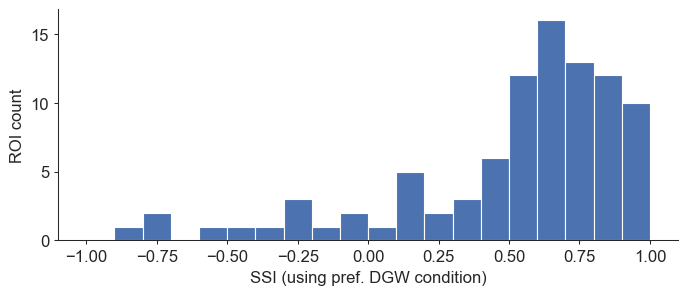

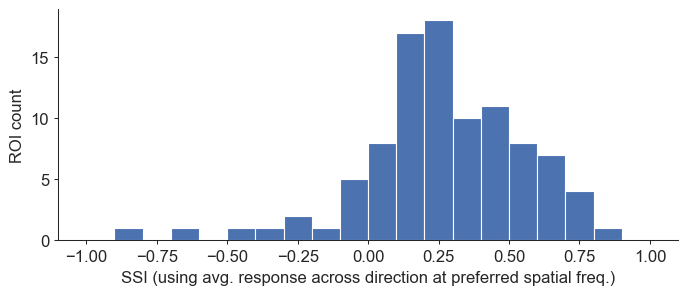

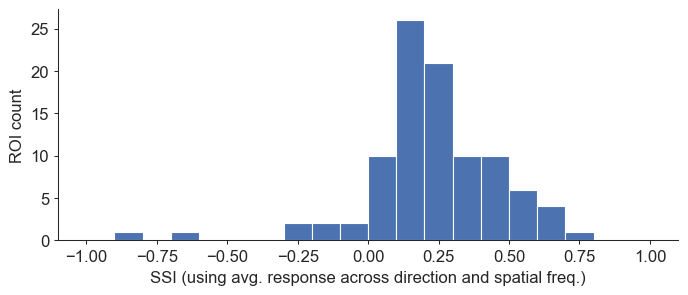

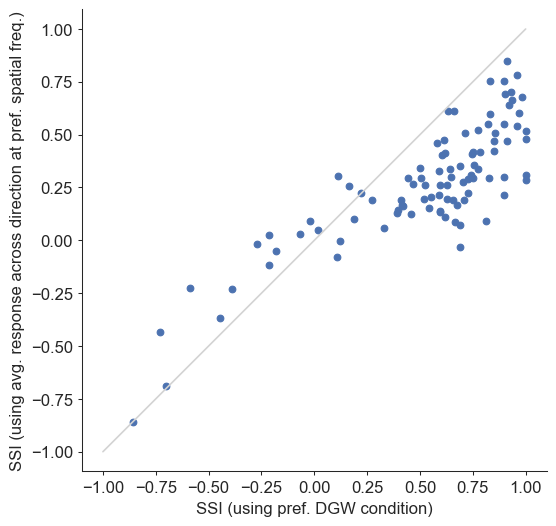

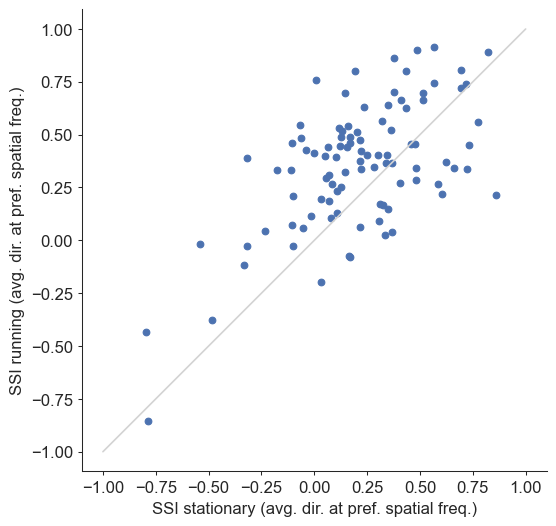

In [90]:
ssi = []
ssi_avg_pref_tf = []
ssi_avg = []
ssi_avg_pref_tf_stationary = []
ssi_avg_pref_tf_running = []

for roi in responsive_rois:
    dgw_pref_dir = dgw.metrics.at[roi, "pref_dir"]
    dgw_pref_sf = dgw.metrics.at[roi, "pref_sf"]

    mean_dgw_resp = dgw.trial_responses.sel(roi=roi).mean(skipna=True).item()
    mean_dgf_resp = dgf.trial_responses.sel(roi=roi).mean(skipna=True).item()
    ssi_avg.append((mean_dgw_resp - mean_dgf_resp) / (mean_dgw_resp + mean_dgf_resp))

    tf_mean_dgw_resp = dgw.trial_responses.sel(roi=roi, spatial_frequency=dgw_pref_sf).mean().item()
    tf_mean_dgf_resp = dgf.trial_responses.sel(roi=roi, spatial_frequency=dgw_pref_sf).mean().item()
    ssi_avg_pref_tf.append((tf_mean_dgw_resp - tf_mean_dgf_resp) / (tf_mean_dgw_resp + tf_mean_dgf_resp))

    pref_dgw_resp = dgw.trial_responses.sel(roi=roi, direction=dgw_pref_dir, spatial_frequency=dgw_pref_sf).mean().item()
    dgf_resp_pref_dgw = dgf.trial_responses.sel(roi=roi, direction=dgw_pref_dir, spatial_frequency=dgw_pref_sf).mean().item()
    ssi.append((pref_dgw_resp - dgf_resp_pref_dgw) / (pref_dgw_resp + dgf_resp_pref_dgw))

    tf_mean_dgw_resp_running = dgw.trial_responses.where(dgw_is_running).sel(roi=roi, spatial_frequency=dgw_pref_sf).mean().item()
    tf_mean_dgf_resp_running = dgf.trial_responses.where(dgf_is_running).sel(roi=roi, spatial_frequency=dgw_pref_sf).mean().item()
    ssi_avg_pref_tf_running.append((tf_mean_dgw_resp_running - tf_mean_dgf_resp_running) / (tf_mean_dgw_resp_running + tf_mean_dgf_resp_running))

    tf_mean_dgw_resp_stationary = dgw.trial_responses.where(dgw_is_stationary).sel(roi=roi, spatial_frequency=dgw_pref_sf).mean().item()
    tf_mean_dgf_resp_stationary = dgf.trial_responses.where(dgf_is_stationary).sel(roi=roi, spatial_frequency=dgw_pref_sf).mean().item()
    ssi_avg_pref_tf_stationary.append((tf_mean_dgw_resp_stationary - tf_mean_dgf_resp_stationary) / (tf_mean_dgw_resp_stationary + tf_mean_dgf_resp_stationary))

plt.figure(figsize=(8, 3))
plt.hist(ssi, bins=np.arange(-1, 1.1, 0.1))
plt.xlabel("SSI (using pref. DGW condition)")
plt.ylabel("ROI count")

plt.figure(figsize=(8, 3))
plt.hist(ssi_avg_pref_tf, bins=np.arange(-1, 1.1, 0.1))
plt.xlabel("SSI (using avg. response across direction at preferred spatial freq.)")
plt.ylabel("ROI count")

plt.figure(figsize=(8, 3))
plt.hist(ssi_avg, bins=np.arange(-1, 1.1, 0.1))
plt.xlabel("SSI (using avg. response across direction and spatial freq.)")
plt.ylabel("ROI count")

plt.figure(figsize=(6, 6))
# plt.scatter(ssi_avg, ssi)
# plt.ylabel("SSI (using avg. response across direction and spatial freq.)")
plt.scatter(ssi, ssi_avg_pref_tf)
plt.xlabel("SSI (using pref. DGW condition)")
plt.ylabel("SSI (using avg. response across direction at pref. spatial freq.)")
plt.axis("equal")
plt.plot([-1, 1], [-1, 1], color="lightgray")

plt.figure(figsize=(6, 6))
plt.scatter(ssi_avg_pref_tf_stationary, ssi_avg_pref_tf_running)
plt.xlabel("SSI stationary (avg. dir. at pref. spatial freq.)")
plt.ylabel("SSI running (avg. dir. at pref. spatial freq.)")
plt.axis("equal")
plt.plot([-1, 1], [-1, 1], color="lightgray")